In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from data_proccessing import  valid_loader,train_loader, labels
from helper import train, evaluate
import os

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


/Users/abigail/Documents/adl/data_proccessing.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, data_entry[data_entry[l]==1][:300]], ignore_index=True)


2832 709
2832 709 886


In [2]:
print(len(labels))

15


In [3]:
num_classes = len(labels)  # Example number of classes

torch.manual_seed(43)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the last layer for multi-class classification
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, num_classes),  # New fully connected layer
    nn.Sigmoid()  # Add Sigmoid activation
)

# Freeze the weights of the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the weights of the last layer
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet.to(device)

# Print the model architecture
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Users/abigail/Documents/adl/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/abigail/Documents/adl/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Clear CUDA memory
torch.cuda.empty_cache()

In [5]:
# Paths for saving
save_dir = "models/resnet_final"
os.makedirs(save_dir, exist_ok=True)

# Define Params
criterion = nn.BCELoss()
num_epochs = 15
learning_rates = [0.001, 0.0005]

# Track losses for visualization
train_losses_dict = {}
valid_losses_dict = {}

# Iterate over different learning rates
for lr in learning_rates:
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=lr)

    best_valid_loss = float('inf')
    train_losses = []  
    valid_losses = []  
    
    for epoch in range(num_epochs):
        avg_train_loss = train(resnet, train_loader, optimizer, criterion, device)
        train_losses.append(avg_train_loss)
        
        valid_loss = evaluate(resnet, valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        
        # Print validation loss
        print(f'Learning Rate: {lr}, Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
        
        # Save the best model if validation loss improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(resnet.state_dict(), os.path.join(save_dir, f'best_model_lr_{lr}.pt'))

    # Store losses for visualization
    train_losses_dict[lr] = train_losses
    valid_losses_dict[lr] = valid_losses

# Save losses dictionaries for visualization later
torch.save(train_losses_dict, os.path.join(save_dir, 'train_losses.pt'))
torch.save(valid_losses_dict, os.path.join(save_dir, 'valid_losses.pt'))

Learning Rate: 0.001, Epoch: 1, Train Loss: 0.3780, Validation Loss: 0.3669
Learning Rate: 0.001, Epoch: 2, Train Loss: 0.3643, Validation Loss: 0.3582
Learning Rate: 0.001, Epoch: 3, Train Loss: 0.3615, Validation Loss: 0.3717
Learning Rate: 0.001, Epoch: 4, Train Loss: 0.3583, Validation Loss: 0.3584
Learning Rate: 0.001, Epoch: 5, Train Loss: 0.3538, Validation Loss: 0.3573
Learning Rate: 0.001, Epoch: 6, Train Loss: 0.3530, Validation Loss: 0.3460
Learning Rate: 0.001, Epoch: 7, Train Loss: 0.3485, Validation Loss: 0.3583
Learning Rate: 0.001, Epoch: 8, Train Loss: 0.3482, Validation Loss: 0.3506
Learning Rate: 0.001, Epoch: 9, Train Loss: 0.3465, Validation Loss: 0.3521
Learning Rate: 0.001, Epoch: 10, Train Loss: 0.3421, Validation Loss: 0.3498
Learning Rate: 0.001, Epoch: 11, Train Loss: 0.3424, Validation Loss: 0.3438
Learning Rate: 0.001, Epoch: 12, Train Loss: 0.3414, Validation Loss: 0.3414
Learning Rate: 0.001, Epoch: 13, Train Loss: 0.3397, Validation Loss: 0.3410
Learning

In [4]:
from data_proccessing import test_loader
from helper import test
import pandas as pd

# Load the model architecture
resnet = models.resnet18() 
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, num_classes), 
    nn.Sigmoid() 
)
criterion = nn.BCELoss()
save_dir = "models/resnet_final"
learning_rates = [0.001, 0.0005]
for lr in learning_rates:
    model_path = os.path.join(save_dir, f'best_model_lr_{lr}.pt')  # Change the filename accordingly
    resnet.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    metrics, loss = test(resnet, test_loader, criterion, device)


    print(metrics, loss)

    Precision  Accuracy    Recall  F1-score
0    0.422680  0.794582  0.245509  0.310606
1    0.000000  0.883747  0.000000  0.000000
2    0.000000  0.878104  0.000000  0.000000
3    0.400000  0.889391  0.063158  0.109091
4    0.692308  0.768623  0.042857  0.080717
5    0.000000  0.917607  0.000000  0.000000
6    0.200000  0.895034  0.011111  0.021053
7    0.000000  0.946953  0.000000  0.000000
8    0.514286  0.714447  0.070866  0.124567
9    0.000000  0.889391  0.000000  0.000000
10   0.000000  0.932280  0.000000  0.000000
11   1.000000  0.882619  0.009524  0.018868
12   0.000000  0.879233  0.000000  0.000000
13   1.000000  0.897291  0.010870  0.021505 0.34433786996773313
    Precision  Accuracy    Recall  F1-score
0    0.800000  0.814898  0.023952  0.046512
1    0.666667  0.884876  0.019417  0.037736
2    0.000000  0.876975  0.000000  0.000000
3    0.429907  0.875847  0.484211  0.455446
4    0.739130  0.775395  0.080952  0.145923
5    0.000000  0.916479  0.000000  0.000000
6    0.33333

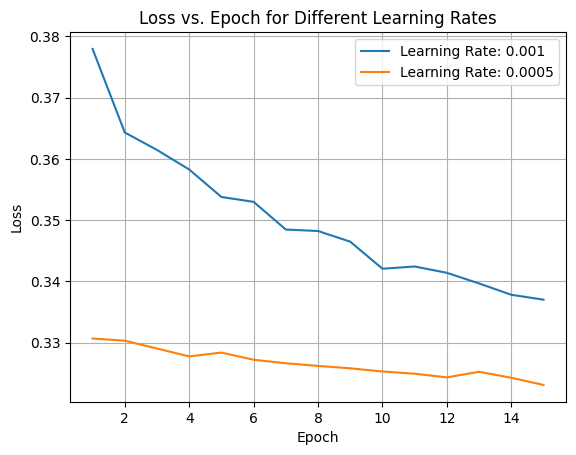

In [5]:
from helper import visualise_loss

save_dir = "models/resnet_final/"
model_path = os.path.join(save_dir, f'train_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)

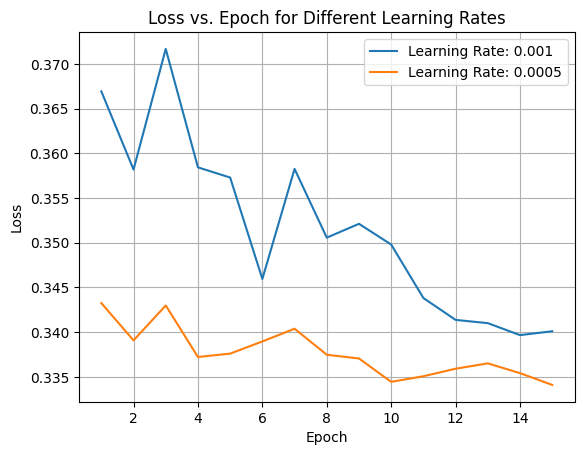

In [6]:
save_dir = "models/resnet_final/"
model_path = os.path.join(save_dir, f'valid_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)